# TP2 - Régression logistique : Une étoile est-elle un pulsar ?

Issue d'un [dataset](https://www.kaggle.com/datasets/colearninglounge/predicting-pulsar-starintermediate) disponible sur Kaggle.

Le dataset pour cette séance correspond à des mesures d'observations d'étoiles pour lesquelles on se pose la question : est-ce un pulsar ? Puisque la réponse est *oui* ou *non*, nous sommes dans le cadre d'un apprentissage supervisé et plus spécifiquement une classification. Nous allons utiliser une régression logistique pour répondre à ce problème.

## Contrôle de la qualité de donnée

Commençons par importer les données et les observer.

In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv("pulsar_stars.csv")
df.head(15)

,Mean_ip,Std_ip,Excess_kurtosis_ip,Skewness_ip,Mean_DM,Std_DM,Excess_kurtosis_DM,Skewness_DM,target
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0
5,93.570312,46.698114,0.531905,0.416721,1.636288,14.545074,10.621748,131.394004,0
6,119.484375,48.765059,0.031460,-0.112168,0.999164,9.279612,19.206230,479.756567,0
7,130.382812,39.844056,-0.158323,0.389540,1.220736,14.378941,13.539456,198.236457,0
8,107.250000,52.627078,0.452688,0.170347,2.331940,14.486853,9.001004,107.972506,0
9,107.257812,39.496488,0.465882,1.162877,4.079431,24.980418,7.397080,57.784738,0


Comme nous travaillons avec un problème de classification, on souhaite connaître la proportion de déséquilibre. C'est la proportion d'observation de la classe d'intérêt dans la totalité du dataset.

**Consigne** : calculer la proportion de déséquilibre.

In [9]:
rate = round(df["target"].mean() * 100, 2)
print(f"Taux de déséquilibre du dataset = {rate}%")

Taux de déséquilibre du dataset = 9.16%


On souhaite avoir une vue rapide du dataset. En exploitant la méthode *describe* on obtient :

In [2]:
df.describe()

,Mean_ip,Std_ip,Excess_kurtosis_ip,Skewness_ip,Mean_DM,Std_DM,Excess_kurtosis_DM,Skewness_DM,target
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


Il ne semble pas y avoir de valeurs aberrantes, mais on souhaite le vérifier. Pour le faire, nous allons tracer la distribution de chacune des colonnes. 

**Consigne** : Ecrire une fonction nommé *plot_column* qui prend en paramètre :
* *df*: un dataset
* *column*: une chaîne de caractère qui correspond au nom de la colonne que l'on va visualiser
Cette fonction a pour objectif d'afficher la distribution de la colonne *column* du dataset *df*.

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

def plot_column(df, column, figsize=(15, 7)):
    plt.figure(figsize=figsize)
    plt.hist(df[column])
    plt.title("Distribution de la colonne %s" % column.capitalize())
    plt.show()

**Consigne** : Exploiter la fonction *plot_column* pour contrôler qu'il n'y a pas de valeurs aberrante.

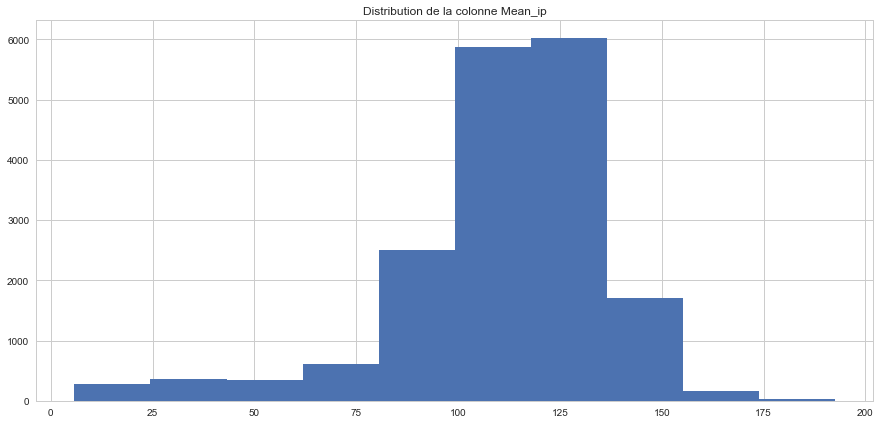

In [15]:
plot_column(df, "Mean_ip")

## Modélisation

Pour mesurer la performance de notre future modélisation, nous allons utiliser la validation croisée et plus spécifiquement la fonction [*cross_val_score*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) de scikit-learn.

**Consigne** : Construire une fonction *performance* qui prend en paramètre un vecteur *vector* et qui affiche la moyenne et l'écart-type au format suivant : *moyenne (+/- ecart-type)*

In [32]:
def performance(vector):
    mean_value = vector.mean()
    std_value = vector.std()
    print(f"Performance : {mean_value:.2f} (+/-{std_value:.2f})")

**Consigne** : réaliser une validation croisée pour la mesure de performance d'une [régression logistique](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). On affichera les performance à l'aide de la fonction *performance*.

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer

model = LogisticRegression(max_iter=1000)
X = df.drop(columns=["target"], axis=1)
y = df["target"]




scores = cross_val_score(model, X, y, cv=5, scoring=make_scorer(f1_score))
performance(scores)

Performance : 0.87 (+/-0.02)


Une régression logistique est censée apprendre la probabilité d'appartenance à la classe d'intérêt. Nous avons donc accès à plusieurs *seuil*. Concrètement, en choisissant un seuil différent de 0.5 (celui par défaut), nous pouvons obtenir avec le même modèle plusieurs prédictions différentes. Nous souhaitons mesurer cela.

**Consigne** : Couper le dataset *df* en une base d'entraînement et une base de test. On utilisera le paramètre *stratify* de la fonction [*train_test_split*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

**Consigne** : Entraîner la régression logistique sur la base d'entraînement puis prédire les probabilités d'appartenance à la classe d'intérêt pour la base de test.

In [25]:
model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
y_proba = model.predict_proba(X_test)

**Consigne** : calculer la performance pour les seuils 0.1, 0.5 et 0.9.

In [40]:
thresholds = [0.1, 0.5, 0.9]
for threshold in thresholds:
    y_pred = y_proba[:, 1] > threshold
    score = f1_score(y_true=y_test, y_pred=y_pred)
    print(f"Seuil {threshold}, f1-score = {score:.2f}")

Seuil 0.1, f1-score = 0.83
Seuil 0.5, f1-score = 0.87
Seuil 0.9, f1-score = 0.80


On souhaite visualiser les courbes de performances selon la valeur du seuil choisi. On souhaite mesurer la performance selon plusieurs métriques :
* La [précision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)
* Le [recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)
* Le [f1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)

**Consigne** : Construire une fonction *plot_metrics* qui prends en paramètre :
* *y_proba* : un vecteur de probabilité d'appartenance à la classe d'intérêt
* *y_true* : un vecteur qui correspond aux valeurs que l'on doit prédire
Elle tracera pour plusieurs seuil (on pourra utiliser la fonction *np.linspace*) la performance pour ces trois métriques.

In [43]:
from sklearn.metrics import precision_score, recall_score

def plot_metrics(y_proba, y_true, figsize=(15, 7)):
    thresholds = np.linspace(start=0.001, stop=0.999, num=25)
    
    plt.figure(figsize=figsize)
    
    for metric in [precision_score, recall_score, f1_score]:
        scores = []
        
        for threshold in thresholds:
            y_pred = y_proba > threshold
            score = metric(y_true=y_test, y_pred=y_pred)
            scores.append(score)
        
        plt.plot(thresholds, scores, label=metric.__name__)
    
    plt.ylim(0, 1)
    plt.title("Valeurs de performance pour plusieurs seuils")
    plt.legend()
    plt.show()

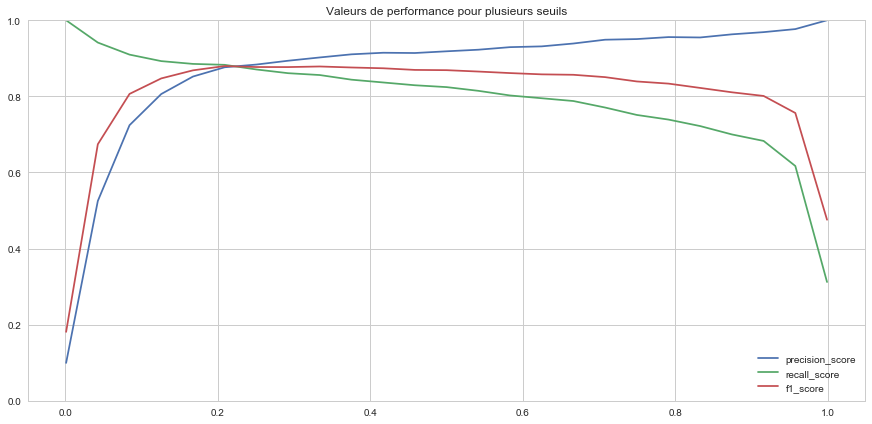

In [44]:
plot_metrics(y_proba[:, 1], y_test)

## Régularisations

Par défaut, l'implémentation de la [régression logistique](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) dans scikit-learn utilise la régularisation $\mathcal{L}_2$.

**Consigne** : Entrainer une régression logitisque sans aucune régularisation.

In [50]:
model = LogisticRegression(penalty='none', max_iter=1000)
scores = cross_val_score(model, X, y, cv=5, scoring=make_scorer(f1_score))
performance(scores)

Performance : 0.88 (+/-0.02)


On cherche à mesurer l'impact de la régularisation $\mathcal{L}_2$ sur la qualité de prédiction. 

**Consigne** : Entraîner plusieurs régression logisitique en faisant varier la force de la régularisation.

In [60]:
strengths = [10**(-digit) for digit in range(-2, 6)]
for strength in strengths:
    model = LogisticRegression(penalty='l2', C=strength, max_iter=1000)
    score = cross_val_score(model, X, y, cv=5, scoring=make_scorer(f1_score)).mean()
    print(f"C={strength} : {score:.2f}")

C=100 : 0.88
C=10 : 0.88
C=1 : 0.87
C=0.1 : 0.86
C=0.01 : 0.84
C=0.001 : 0.84
C=0.0001 : 0.83
C=1e-05 : 0.80


## BONUS

1. Fonction pour trouver le seuil optimal selon le f1-score
2. Fonction de visualisation de l'impact de la régularisation
3. Généralisation à d'autre forme de régularisations